# Radom bcc alloy

In [1]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from lammps_implicit_der.systems import BccBinary
from lammps_implicit_der import SNAP
from lammps_implicit_der.tools import mpi_print, \
                                      get_default_data_path, \
                                      initialize_mpi, \
                                      error_tools, \
                                      TimingGroup


## Define a non-perturbed random alloy system

In [2]:
# Check if the bcc_random.data file exists
datafilename = 'bcc_random.data'
datafile = datafilename if os.path.exists(datafilename) else None

#datafile = None

bcc_alloy_non_perturb = BccBinary(datafile=datafile,
                                  snapcoeff_filename='NiMo.snapcoeff',
                                  num_cells=2,
                                  specie_B_concentration=0.5,
                                  minimize=True)

if datafile is None:
    bcc_alloy_non_perturb.write_data(datafilename)

None
Running LAMMPS with the following arguments:
-screen none -log none
Reading datafile bcc_random.data
Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg
Number of atoms: 16, largest force value: 2.257e-09, force norm: 5.999e-09


In [3]:
print(bcc_alloy_non_perturb.cell)
print(bcc_alloy_non_perturb.species)

[[6.26 0.   0.  ]
 [0.   6.26 0.  ]
 [0.   0.   6.26]]
[1 1 1 2 2 2 2 2 2 1 1 2 1 1 1 1]


## SNAP potential parameters perturbation

In [4]:
print(bcc_alloy_non_perturb.pot.Theta_dict['Mo'])

{'elem_params': {'radius': 0.575, 'weight': 1.0}, 'beta0': -11.1413071988, 'Theta': array([ 0.00217993,  0.02117406,  0.05027489,  0.01271017,  0.32806724,
        0.06901471,  0.1782036 ,  0.00128021,  0.06856159,  0.02934277,
        0.0085863 , -0.00900972,  0.00302195,  0.02371238,  0.00319153,
        0.03359465,  0.06278455, -0.06161855, -0.02141344, -0.0348541 ,
        0.01435036,  0.00391291,  0.02266774, -0.02309605, -0.02843036,
        0.00857356,  0.00335881,  0.03927386, -0.00041452, -0.00370094])}


In [5]:
# Get the Mo Theta parameters
Theta_Mo = bcc_alloy_non_perturb.pot.Theta_dict['Mo']['Theta'].copy()

# Strongly perturb the Mo Theta parameters
delta = 0.5

dTheta = Theta_Mo * np.random.uniform(-1.0, 1.0, size=Theta_Mo.shape) * delta

Theta_Mo_perturb = Theta_Mo + dTheta

# Copy from the original potential
Theta_dict_perturb = deepcopy(bcc_alloy_non_perturb.pot.Theta_dict)
Theta_dict_perturb['Mo']['Theta'] = Theta_Mo_perturb

snapparam_dict = deepcopy(bcc_alloy_non_perturb.pot.snapparam_dict)
elem_list = bcc_alloy_non_perturb.pot.elem_list.copy()

# Define a SNAP instance with the perturbed parameters
perturbed_snap = SNAP(elem_list, Theta_dict_perturb, snapparam_dict)

# Save the perturbed SNAP coefficients to a file
snapcoeff_filename = 'NiMo_Mo_perturbed.snapcoeff'
snapparam_filename = 'NiMo_Mo_perturbed.snapparam'

# Do it once
#today_is_the_day = True
today_is_the_day = False

if today_is_the_day:
    perturbed_snap.to_files(path='.',
                            snapcoeff_filename=snapcoeff_filename,
                            snapparam_filename=snapparam_filename,
                            overwrite=True,
                            verbose=True)

## Perturbed random alloy system

In [6]:
bcc_alloy_perturb = BccBinary(datafile=datafile,
                              data_path='.',
                              snapcoeff_filename='NiMo_Mo_perturbed.snapcoeff',
                              num_cells=3,
                              minimize=True)

None
Running LAMMPS with the following arguments:
-screen none -log none
Reading datafile bcc_random.data
Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg
Number of atoms: 16, largest force value: 3.193e-09, force norm: 9.398e-09


## Coordinates

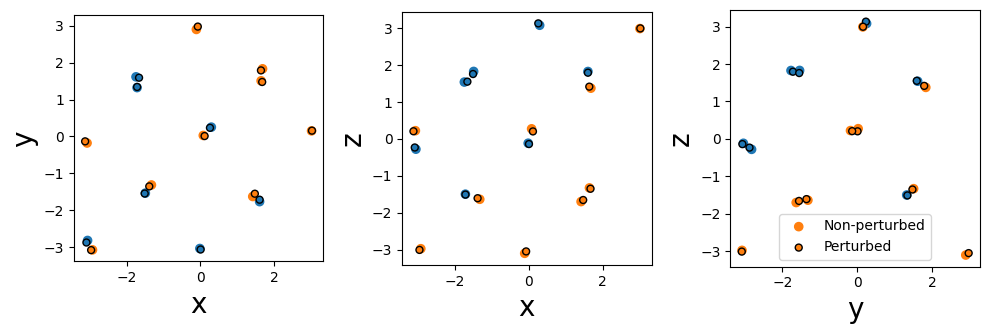

In [7]:
X0 = bcc_alloy_non_perturb.X_coord.copy()
X1 = bcc_alloy_perturb.X_coord.copy()

X1 = X0.copy() + bcc_alloy_non_perturb.minimum_image(X1 - X0)

X0 = X0.reshape(-1, 3)
X1 = X1.reshape(-1, 3)

species = bcc_alloy_non_perturb.species

def plot_coords(X0, X1, species):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    ax_labels = ['x', 'y', 'z']
    ax_combs = [(0, 1), (0, 2), (1, 2)]
    specie_color = {1: 'tab:orange', 2: 'tab:blue'}

    colors = [specie_color[specie] for specie in species]

    for i, ax in enumerate(axes):
        ax.set_aspect('equal')
        ax.scatter(X0[:, ax_combs[i][0]], X0[:, ax_combs[i][1]], s=35, label='Non-perturbed', c=colors)
        ax.scatter(X1[:, ax_combs[i][0]], X1[:, ax_combs[i][1]], s=25, label='Perturbed', c=colors, edgecolors='black')
        ax.set_xlabel(ax_labels[ax_combs[i][0]], fontsize=20)
        ax.set_ylabel(ax_labels[ax_combs[i][1]], fontsize=20)

    # tight layout
    plt.tight_layout()

    ax.legend()
    plt.show()

plot_coords(X0, X1, species)

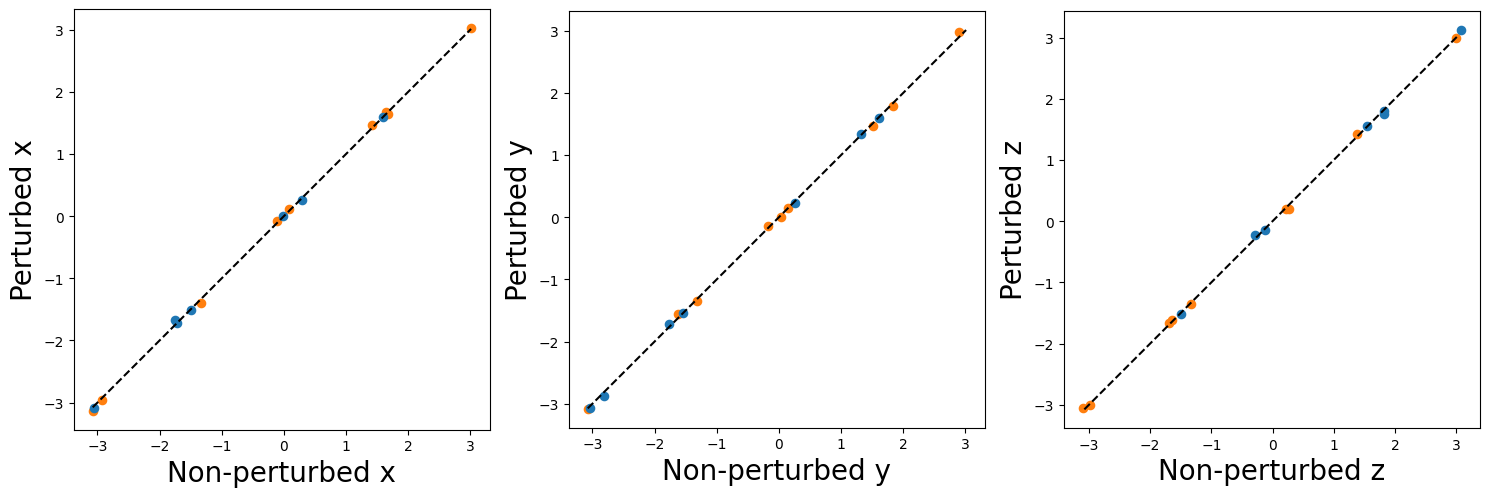

In [8]:
# Plot X0 against X1
def compare_coords(X0, X1, species):

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    ax_names = ['x', 'y', 'z']

    # Coordinates of species 1 and 2
    X0_1 = X0[species == 1]
    X0_2 = X0[species == 2]

    X1_1 = X1[species == 1]
    X1_2 = X1[species == 2]

    for i, ax in enumerate(axes):
        ax.set_aspect('equal')
        ax.scatter(X0_1[:, i], X1_1[:, i], s=35, label='Species 1', color='tab:orange')
        ax.scatter(X0_2[:, i], X1_2[:, i], s=35, label='Species 2', color='tab:blue')
        ax.set_xlabel(f'Non-perturbed {ax_names[i]}', fontsize=20)
        ax.set_ylabel(f'Perturbed {ax_names[i]}', fontsize=20)

        ax.plot([np.min(X0[:, 0]), np.max(X0[:, 0])], [np.min(X0[:, 0]), np.max(X0[:, 0])], 'k--')

    plt.tight_layout()
    ax.set_aspect('equal')

    plt.show()

compare_coords(X0, X1, bcc_alloy_non_perturb.species)

## Potential difference

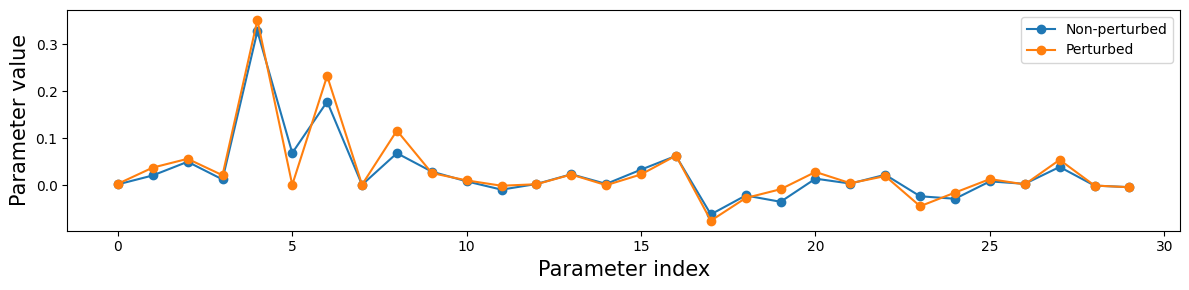

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))

Theta0 = bcc_alloy_non_perturb.pot.Theta_dict['Mo']['Theta'].copy()
Theta1 = bcc_alloy_perturb.pot.Theta_dict['Mo']['Theta'].copy()

ax.plot(Theta0, marker='o', ls='-', label='Non-perturbed')
ax.plot(Theta1, marker='o', ls='-', label='Perturbed')

ax.set_xlabel('Parameter index', fontsize=15)
ax.set_ylabel('Parameter value', fontsize=15)

plt.legend()
plt.tight_layout()
plt.show()

## Potential parameters minimization using the implicit derivative technique

In [10]:
# Re-initialize the non-perturbed system before the minimization
bcc_alloy_minim = BccBinary(datafile=datafile,
                            snapcoeff_filename='NiMo.snapcoeff',
                            num_cells=3,
                            specie_B_concentration=0.5,
                            minimize=True)

None
Running LAMMPS with the following arguments:
-screen none -log none
Reading datafile bcc_random.data
Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg
Number of atoms: 16, largest force value: 2.257e-09, force norm: 5.999e-09


In [11]:
X0 = bcc_alloy_non_perturb.X_coord.copy()
X1 = bcc_alloy_perturb.X_coord.copy()

X_target = X0.copy() + bcc_alloy_non_perturb.minimum_image(X1 - X0)

bcc_alloy_perturb_minimized, error_array, \
min_X, min_Theta = error_tools.minimize_loss(
                            bcc_alloy_minim,
                            X_target,
                            comm=None,
                            step=1e-4,
                            adaptive_step=True,
                            maxiter=20,
                            error_tol=1e-5,
                            der_ftol=1e-4,
                            der_method='inverse',
                            der_adaptive_alpha=True,
                            der_alpha=0.5,
                            der_maxiter=500,
                            pickle_name='bcc_alloy_minimization.pickle',
                            verbosity=3,
                            minimize_at_iters=True,
                            apply_hard_constraints=False,
                            binary=True
                            )


=======================Running the parameter optimization=======================

                 Initial error: 3.918e-02

Iteration 1 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 316.82it/s]


                     Step size: 1.003e-04

           -------------Params-------------
             Largest dX/dTheta: 3.006e+01
                Largest dTheta: 1.628e-03

           -----------Positions------------
                    Largest dX: 8.195e-02
                 Std Dev of dX: 3.063e-02

           -------------Forces-------------
           Largest force value: 6.325e-02; Norm: 1.699e-01
                        Energy: -1.2387628268e+02

           ----Forces after minimization---


           Largest force value: 4.790e-05; Norm: 1.495e-04
                        Energy: -1.2387961373e+02


           -------------Errors-------------
                 Current error: 1.495e-02
                 Actual change: 2.423e-02
Iteration 2 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 316.18it/s]


                     Step size: 1.615e-03

           -------------Params-------------
             Largest dX/dTheta: 2.903e+01
                Largest dTheta: 3.715e-03

           -----------Positions------------
                    Largest dX: 5.615e-02
                 Std Dev of dX: 2.237e-02

           -------------Forces-------------
           Largest force value: 6.215e-02; Norm: 1.502e-01
                        Energy: -1.2350986755e+02

           ----Forces after minimization---


           Largest force value: 7.344e-05; Norm: 2.144e-04
                        Energy: -1.2351168545e+02


           -------------Errors-------------
                 Current error: 3.635e-03
                 Actual change: 1.132e-02
Iteration 3 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 289.50it/s]


                     Step size: 1.605e-04

           -------------Params-------------
             Largest dX/dTheta: 2.228e+01
                Largest dTheta: 6.509e-05

           -----------Positions------------
                    Largest dX: 2.284e-03
                 Std Dev of dX: 1.277e-03

           -------------Forces-------------
           Largest force value: 1.149e-04; Norm: 3.047e-04
                        Energy: -1.2343646802e+02

           ----Forces after minimization---


           Largest force value: 5.890e-07; Norm: 1.532e-06
                        Energy: -1.2343646804e+02


           -------------Errors-------------
                 Current error: 3.602e-03
                 Actual change: 3.302e-05
Iteration 4 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 312.32it/s]


                     Step size: 1.505e-04

           -------------Params-------------
             Largest dX/dTheta: 2.189e+01
                Largest dTheta: 7.838e-05

           -----------Positions------------
                    Largest dX: 2.513e-03
                 Std Dev of dX: 1.335e-03

           -------------Forces-------------
           Largest force value: 1.732e-04; Norm: 4.147e-04
                        Energy: -1.2345927259e+02

           ----Forces after minimization---


           Largest force value: 5.003e-07; Norm: 1.401e-06
                        Energy: -1.2345927267e+02


           -------------Errors-------------
                 Current error: 3.559e-03
                 Actual change: 4.249e-05
Iteration 5 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 311.40it/s]


                     Step size: 1.515e-04

           -------------Params-------------
             Largest dX/dTheta: 2.263e+01
                Largest dTheta: 6.308e-05

           -----------Positions------------
                    Largest dX: 2.281e-03
                 Std Dev of dX: 1.273e-03

           -------------Forces-------------
           Largest force value: 7.149e-05; Norm: 1.924e-04
                        Energy: -1.2338653453e+02

           ----Forces after minimization---


           Largest force value: 2.598e-07; Norm: 7.309e-07
                        Energy: -1.2338653454e+02


           -------------Errors-------------
                 Current error: 3.521e-03
                 Actual change: 3.843e-05
Iteration 6 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 319.63it/s]


                     Step size: 1.609e-04

           -------------Params-------------
             Largest dX/dTheta: 2.205e+01
                Largest dTheta: 7.849e-05

           -----------Positions------------
                    Largest dX: 2.390e-03
                 Std Dev of dX: 1.268e-03

           -------------Forces-------------
           Largest force value: 1.596e-04; Norm: 3.867e-04
                        Energy: -1.2340544117e+02

           ----Forces after minimization---


           Largest force value: 5.032e-07; Norm: 1.331e-06
                        Energy: -1.2340544124e+02


           -------------Errors-------------
                 Current error: 3.483e-03
                 Actual change: 3.804e-05
Iteration 7 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 320.78it/s]


                     Step size: 1.390e-04

           -------------Params-------------
             Largest dX/dTheta: 2.276e+01
                Largest dTheta: 6.098e-05

           -----------Positions------------
                    Largest dX: 2.171e-03
                 Std Dev of dX: 1.218e-03

           -------------Forces-------------
           Largest force value: 6.929e-05; Norm: 1.854e-04
                        Energy: -1.2333773705e+02

           ----Forces after minimization---


           Largest force value: 2.567e-07; Norm: 7.008e-07
                        Energy: -1.2333773706e+02


           -------------Errors-------------
                 Current error: 3.447e-03
                 Actual change: 3.531e-05
Iteration 8 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 316.67it/s]


                     Step size: 1.729e-04

           -------------Params-------------
             Largest dX/dTheta: 2.220e+01
                Largest dTheta: 7.936e-05

           -----------Positions------------
                    Largest dX: 2.297e-03
                 Std Dev of dX: 1.218e-03

           -------------Forces-------------
           Largest force value: 1.498e-04; Norm: 3.666e-04
                        Energy: -1.2335319382e+02

           ----Forces after minimization---


           Largest force value: 4.466e-07; Norm: 1.293e-06
                        Energy: -1.2335319388e+02


           -------------Errors-------------
                 Current error: 3.413e-03
                 Actual change: 3.484e-05
Iteration 9 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 315.79it/s]


                     Step size: 1.286e-04

           -------------Params-------------
             Largest dX/dTheta: 2.290e+01
                Largest dTheta: 5.926e-05

           -----------Positions------------
                    Largest dX: 2.106e-03
                 Std Dev of dX: 1.178e-03

           -------------Forces-------------
           Largest force value: 6.780e-05; Norm: 1.804e-04
                        Energy: -1.2328952195e+02

           ----Forces after minimization---


           Largest force value: 2.540e-07; Norm: 6.825e-07
                        Energy: -1.2328952196e+02


           -------------Errors-------------
                 Current error: 3.379e-03
                 Actual change: 3.313e-05
Iteration 10 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 320.23it/s]


                     Step size: 1.865e-04

           -------------Params-------------
             Largest dX/dTheta: 2.234e+01
                Largest dTheta: 8.086e-05

           -----------Positions------------
                    Largest dX: 2.229e-03
                 Std Dev of dX: 1.181e-03

           -------------Forces-------------
           Largest force value: 1.428e-04; Norm: 3.525e-04
                        Energy: -1.2330185773e+02

           ----Forces after minimization---


           Largest force value: 4.668e-07; Norm: 1.249e-06
                        Energy: -1.2330185780e+02


           -------------Errors-------------
                 Current error: 3.347e-03
                 Actual change: 3.252e-05
Iteration 11 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 319.70it/s]


                     Step size: 1.198e-04

           -------------Params-------------
             Largest dX/dTheta: 2.304e+01
                Largest dTheta: 5.788e-05

           -----------Positions------------
                    Largest dX: 2.065e-03
                 Std Dev of dX: 1.150e-03

           -------------Forces-------------
           Largest force value: 6.670e-05; Norm: 1.769e-04
                        Energy: -1.2324143700e+02

           ----Forces after minimization---


           Largest force value: 2.568e-07; Norm: 6.729e-07
                        Energy: -1.2324143701e+02


           -------------Errors-------------
                 Current error: 3.315e-03
                 Actual change: 3.162e-05
Iteration 12 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 297.84it/s]


                     Step size: 2.018e-04

           -------------Params-------------
             Largest dX/dTheta: 2.249e+01
                Largest dTheta: 8.291e-05

           -----------Positions------------
                    Largest dX: 2.179e-03
                 Std Dev of dX: 1.154e-03

           -------------Forces-------------
           Largest force value: 1.379e-04; Norm: 3.428e-04
                        Energy: -1.2325086909e+02

           ----Forces after minimization---


           Largest force value: 4.670e-07; Norm: 1.233e-06
                        Energy: -1.2325086915e+02


           -------------Errors-------------
                 Current error: 3.284e-03
                 Actual change: 3.085e-05
Iteration 13 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 314.44it/s]


                     Step size: 1.123e-04

           -------------Params-------------
             Largest dX/dTheta: 2.319e+01
                Largest dTheta: 5.679e-05

           -----------Positions------------
                    Largest dX: 2.039e-03
                 Std Dev of dX: 1.130e-03

           -------------Forces-------------
           Largest force value: 6.607e-05; Norm: 1.746e-04
                        Energy: -1.2319308390e+02

           ----Forces after minimization---


           Largest force value: 2.625e-07; Norm: 6.693e-07
                        Energy: -1.2319308391e+02


           -------------Errors-------------
                 Current error: 3.254e-03
                 Actual change: 3.061e-05
Iteration 14 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 303.75it/s]


                     Step size: 2.464e-04

           -------------Params-------------
             Largest dX/dTheta: 2.267e+01
                Largest dTheta: 9.476e-05

           -----------Positions------------
                    Largest dX: 2.235e-03
                 Std Dev of dX: 1.180e-03

           -------------Forces-------------
           Largest force value: 1.210e-04; Norm: 3.533e-04
                        Energy: -1.2319669468e+02

           ----Forces after minimization---


           Largest force value: 4.379e-07; Norm: 1.274e-06
                        Energy: -1.2319669475e+02


           -------------Errors-------------
                 Current error: 3.221e-03
                 Actual change: 3.333e-05
Iteration 15 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 297.99it/s]


                     Step size: 1.018e-04

           -------------Params-------------
             Largest dX/dTheta: 2.337e+01
                Largest dTheta: 5.662e-05

           -----------Positions------------
                    Largest dX: 2.067e-03
                 Std Dev of dX: 1.139e-03

           -------------Forces-------------
           Largest force value: 6.789e-05; Norm: 1.766e-04
                        Energy: -1.2314097558e+02

           ----Forces after minimization---


           Largest force value: 2.703e-07; Norm: 6.807e-07
                        Energy: -1.2314097559e+02


           -------------Errors-------------
                 Current error: 3.189e-03
                 Actual change: 3.125e-05
Iteration 16 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 295.91it/s]


                     Step size: 1.552e-03

           -------------Params-------------
             Largest dX/dTheta: 2.304e+01
                Largest dTheta: 5.051e-04

           -----------Positions------------
                    Largest dX: 5.430e-03
                 Std Dev of dX: 2.583e-03

           -------------Forces-------------
           Largest force value: 5.496e-04; Norm: 1.457e-03
                        Energy: -1.2297928716e+02

           ----Forces after minimization---


           Largest force value: 1.358e-06; Norm: 4.632e-06
                        Energy: -1.2297928814e+02


           -------------Errors-------------
                 Current error: 3.047e-03
                 Actual change: 1.425e-04
Iteration 17 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 305.85it/s]


                     Step size: 6.708e-05

           -------------Params-------------
             Largest dX/dTheta: 2.493e+01
                Largest dTheta: 1.029e-04

           -----------Positions------------
                    Largest dX: 4.343e-03
                 Std Dev of dX: 2.344e-03

           -------------Forces-------------
           Largest force value: 1.539e-03; Norm: 2.967e-03
                        Energy: -1.2289269650e+02

           ----Forces after minimization---


           Largest force value: 3.853e-06; Norm: 1.170e-05
                        Energy: -1.2289269772e+02


           -------------Errors-------------
                 Current error: 2.851e-03
                 Actual change: 1.955e-04
Iteration 18 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 299.65it/s]


                     Step size: 1.095e-04

           -------------Params-------------
             Largest dX/dTheta: 2.456e+01
                Largest dTheta: 5.079e-05

           -----------Positions------------
                    Largest dX: 2.025e-03
                 Std Dev of dX: 1.068e-03

           -------------Forces-------------
           Largest force value: 6.971e-05; Norm: 1.777e-04
                        Energy: -1.2283982080e+02

           ----Forces after minimization---


           Largest force value: 3.364e-07; Norm: 7.779e-07
                        Energy: -1.2283982081e+02


           -------------Errors-------------
                 Current error: 2.822e-03
                 Actual change: 2.894e-05
Iteration 19 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 317.76it/s]


                     Step size: 1.681e-04

           -------------Params-------------
             Largest dX/dTheta: 2.406e+01
                Largest dTheta: 6.800e-05

           -----------Positions------------
                    Largest dX: 2.021e-03
                 Std Dev of dX: 1.072e-03

           -------------Forces-------------
           Largest force value: 1.148e-04; Norm: 3.016e-04
                        Energy: -1.2285062585e+02

           ----Forces after minimization---


           Largest force value: 4.657e-07; Norm: 1.169e-06
                        Energy: -1.2285062590e+02


           -------------Errors-------------
                 Current error: 2.797e-03
                 Actual change: 2.560e-05
Iteration 20 / 20
Computing dX/dTheta using inverse method...


100%|██████████| 48/48 [00:00<00:00, 315.89it/s]


                     Step size: 1.014e-04

           -------------Params-------------
             Largest dX/dTheta: 2.474e+01
                Largest dTheta: 4.981e-05

           -----------Positions------------
                    Largest dX: 1.983e-03
                 Std Dev of dX: 1.052e-03

           -------------Forces-------------
           Largest force value: 6.276e-05; Norm: 1.699e-04
                        Energy: -1.2280020876e+02

           ----Forces after minimization---


           Largest force value: 2.683e-07; Norm: 8.463e-07
                        Energy: -1.2280020878e+02


           -------------Errors-------------
                 Current error: 2.769e-03
                 Actual change: 2.767e-05

Number of iterations: 20
Converged: False
Final error: 0.0027690869128992367

==================== TIMING SUMMARY: minimize_loss ===================
                                     Tag  Time (s)     Calls     
----------------------------------------------------------------------
      ▷----------------------------total  4.37898      1         
                               dX_dTheta  3.16694      20        
                       minimize at iters  0.95686      20        




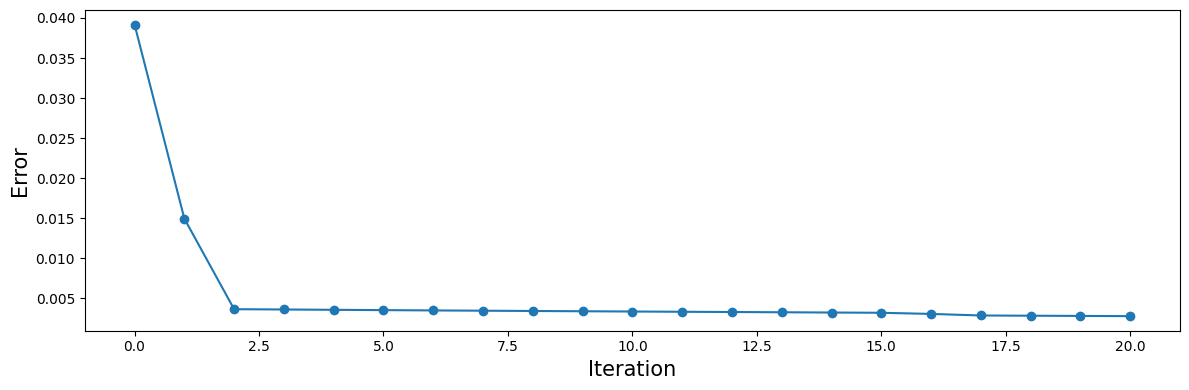

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

ax.plot(error_array, marker='o', ls='-')
ax.set_xlabel('Iteration', fontsize=15)
ax.set_ylabel('Error', fontsize=15)

plt.tight_layout()
plt.show()

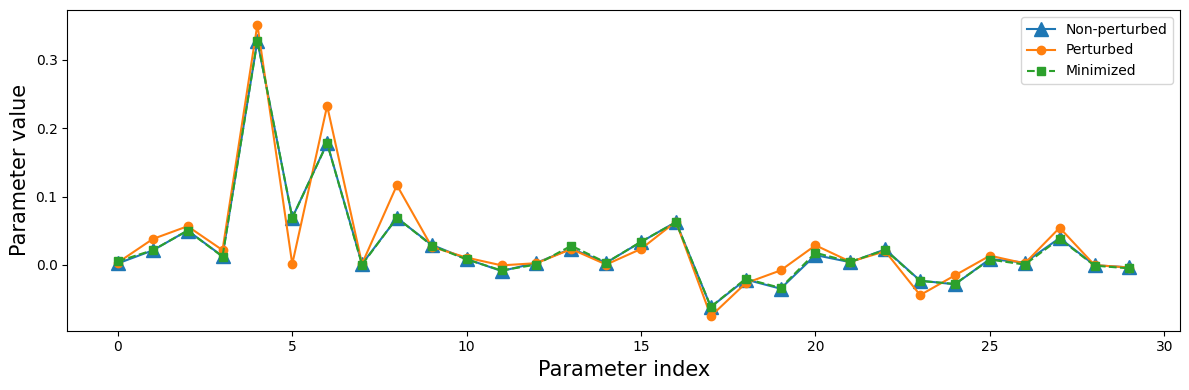

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

Theta0 = bcc_alloy_non_perturb.pot.Theta_dict['Mo']['Theta'].copy()
Theta1 = bcc_alloy_perturb.pot.Theta_dict['Mo']['Theta'].copy()
Theta2 = bcc_alloy_minim.pot.Theta_dict['Mo']['Theta'].copy()

ax.plot(Theta0, marker='^', ls='-', ms=10, label='Non-perturbed')
ax.plot(Theta1, marker='o', ls='-', label='Perturbed')
ax.plot(Theta2, marker='s', ls='--', label='Minimized')

ax.set_xlabel('Parameter index', fontsize=15)
ax.set_ylabel('Parameter value', fontsize=15)

plt.legend()
plt.tight_layout()
plt.show()

In [14]:
X0_3D = bcc_alloy_non_perturb.X_coord.copy().reshape(-1, 3)
X1_3D = bcc_alloy_perturb.X_coord.copy().reshape(-1, 3)
min_X_3D = min_X.reshape(-1, 3)
species = bcc_alloy_non_perturb.species

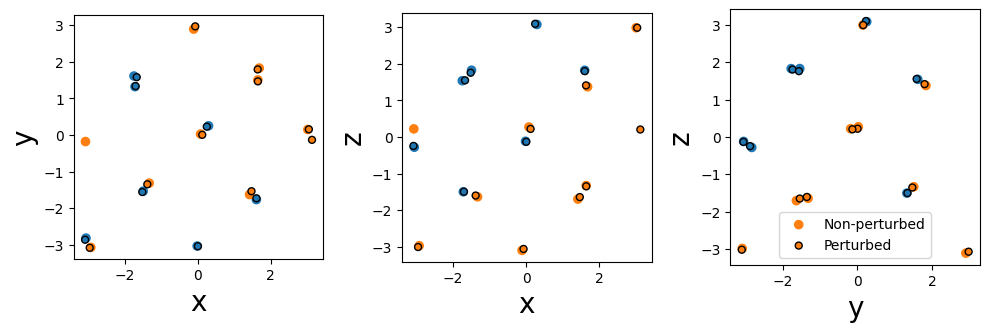

In [15]:
plot_coords(X0_3D, min_X_3D, species)

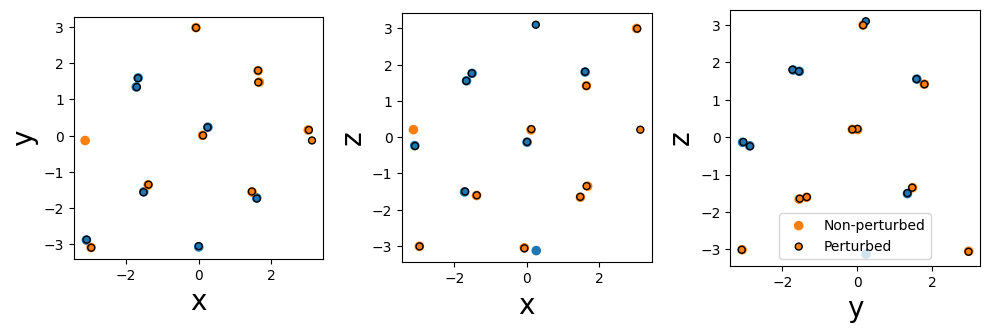

In [16]:
plot_coords(X1_3D, min_X_3D, species)

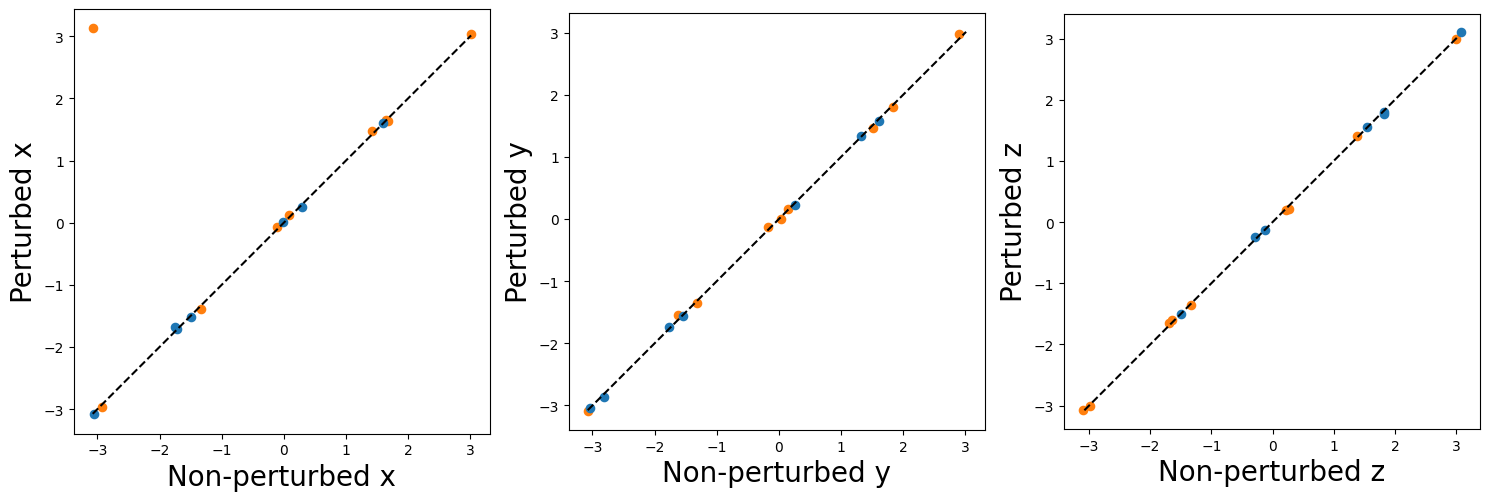

In [17]:
compare_coords(X0_3D, min_X_3D, species)

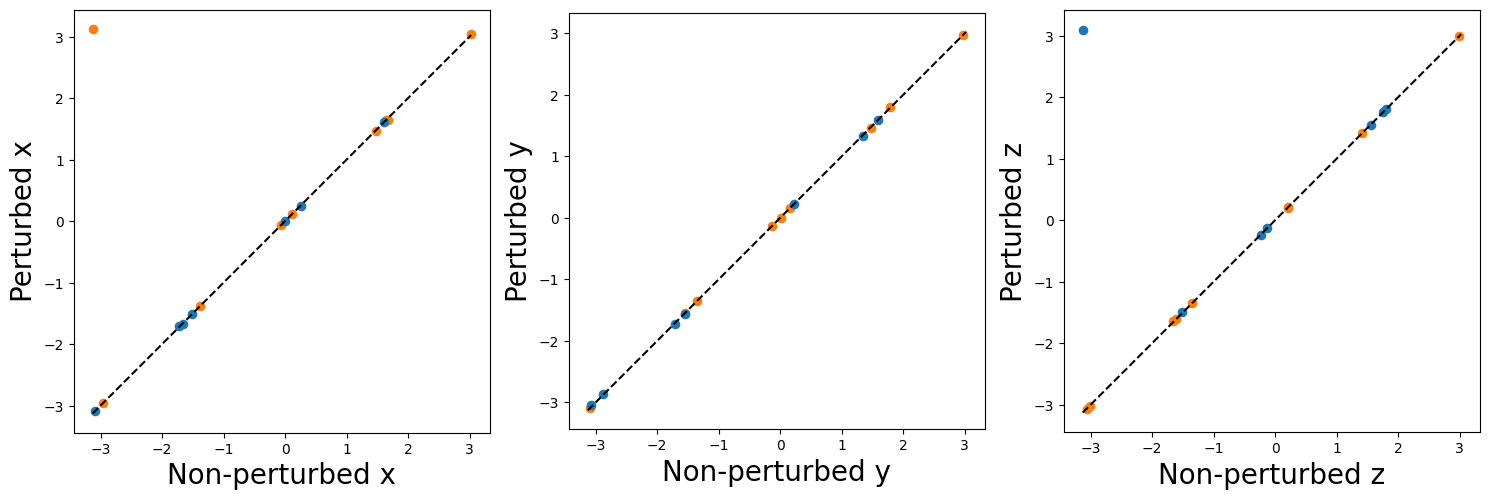

In [18]:
compare_coords(X1_3D, min_X_3D, species)